# **Exercise 10.2**
# **healthy-or-pneumonia**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Datasets
#Check the present working directory using pwd command

/content/gdrive/My Drive/Datasets


In [4]:
!ls

 apple-or-tomato	     Exercise_10_1.ipynb   pneumonia-or-healthy
'B16341_10_For FD_v1.docx'   Exercise_10_2.ipynb


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [3]:
training_data = []

In [4]:
img_size = 416

In [5]:
assign_dict = {"healthy":0, "pneumonia":1}

In [6]:
directory = "/content/gdrive/My Drive/Datasets/pneumonia-or-healhy/training_set"

In [7]:
import os
import cv2

In [8]:
for sub_directory in os.listdir(directory):
        inner_directory = os.path.join(directory,sub_directory)
        for i in os.listdir(inner_directory):
            try:
                img = cv2.imread(os.path.join(inner_directory,i),1)
                img = cv2.resize(img,(100,100))
                training_data.append([img,assign_dict[sub_directory]])
            except:
                pass

In [9]:
import random
random.shuffle(training_data)

In [10]:
len(training_data)

2750

In [11]:
import seaborn as sns

In [12]:
sns.set_style('darkgrid')

In [13]:
f = []

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


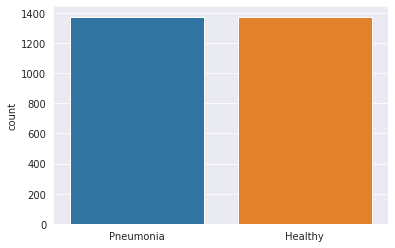

In [14]:
for each in training_data:
    if(each[1] == 0):
        f.append("Healthy")
    else:
        f.append("Pneumonia")
sns.countplot(f);

In [15]:
testing_data = []

In [16]:
directory = "/content/gdrive/My Drive/Datasets/pneumonia-or-healhy/test_set"

In [17]:
for sub_directory in os.listdir(directory):
    inner_directory = os.path.join(directory,sub_directory)
    for i in os.listdir(inner_directory):
        try:
            img = cv2.imread(os.path.join(inner_directory,i),1)
            img = cv2.resize(img,(100,100))
            testing_data.append([img,assign_dict[sub_directory]])
        except:
            pass

In [18]:
len(testing_data)

1180

In [19]:
X_train = []
y_train = []
for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

In [20]:
import numpy as np

X_train = np.array(X_train)/255.0
X_train = X_train.reshape(-1,100,100,3)
y_train = np.array(y_train)

In [21]:
X_test = []
y_test = []
for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)

In [22]:
X_test = np.array(X_test)/255.0
X_test = X_test.reshape(-1,100,100,3)
y_test = np.array(y_test)

In [24]:
import matplotlib.pyplot as plt

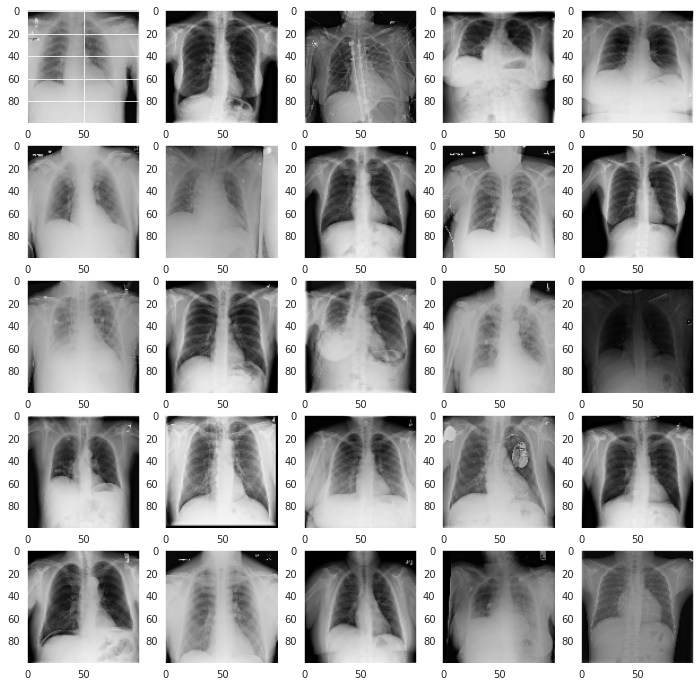

In [25]:
w=10
h=10
fig=plt.figure(figsize=(12,12))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(img))
    plt.rcParams["axes.grid"] = False
plt.show()

In [26]:
import tensorflow as tf

In [27]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense

In [28]:
def relu_batchnorm_layer(input):
    return BatchNormalization()(ReLU()(input))

In [29]:
def residual_block(input, downsample: bool, filters: int, kernel_size: int = 3):
    int_output = Conv2D(filters=filters, kernel_size=kernel_size, 
                        strides= (1 if not downsample else 2), 
                        padding="same")(input)
    int_output = relu_batchnorm_layer(int_output)
    int_output = Conv2D(filters=filters, kernel_size=kernel_size, 
                        padding="same")(int_output)

    if downsample:
        int_output2 = Conv2D(filters=filters, kernel_size=1, strides=2,
                             padding="same")(input)
        output = Add()([int_output2, int_output]) 
    else:
        output = Add()([input, int_output])

    output = relu_batchnorm_layer(output)
    return output

In [30]:
from tensorflow.keras.models import Model

In [31]:
inputs = Input(shape=(100, 100, 3))
num_filters = 32
    
t = BatchNormalization()(inputs)
t = Conv2D(kernel_size=3,
           strides=1,
           filters=32,
           padding="same")(t)
t = relu_batchnorm_layer(t)
    
num_blocks_list = [1, 3, 5, 6, 1]
for i in range(len(num_blocks_list)):
    num_blocks = num_blocks_list[i]
    for j in range(num_blocks):
        t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
    num_filters *= 2
    
t = AveragePooling2D(4)(t)
t = Flatten()(t)
outputs = Dense(1, activation='sigmoid')(t)
    
model = Model(inputs, outputs)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 896         batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 100, 100, 32) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [33]:
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
history=model.fit(X_train,y_train,batch_size = 32,epochs=50,validation_split = 0.1)

Epoch 1/50
78/78 [==============================] - 8s 100ms/step - loss: 0.6498 - accuracy: 0.6780 - val_loss: 0.7368 - val_accuracy: 0.4364
Epoch 2/50
78/78 [==============================] - 7s 89ms/step - loss: 0.5010 - accuracy: 0.7547 - val_loss: 1.2866 - val_accuracy: 0.5127
Epoch 3/50
78/78 [==============================] - 7s 89ms/step - loss: 0.4669 - accuracy: 0.7758 - val_loss: 1.0730 - val_accuracy: 0.6145
Epoch 4/50
78/78 [==============================] - 7s 89ms/step - loss: 0.4481 - accuracy: 0.7834 - val_loss: 0.7578 - val_accuracy: 0.7309
Epoch 5/50
78/78 [==============================] - 7s 89ms/step - loss: 0.4445 - accuracy: 0.7964 - val_loss: 0.4294 - val_accuracy: 0.8145
Epoch 6/50
78/78 [==============================] - 7s 89ms/step - loss: 0.4469 - accuracy: 0.7895 - val_loss: 0.4947 - val_accuracy: 0.7891
Epoch 7/50
78/78 [==============================] - 7s 89ms/step - loss: 0.4162 - accuracy: 0.8117 - val_loss: 0.5450 - val_accuracy: 0.8145
Epoch 8/50
7

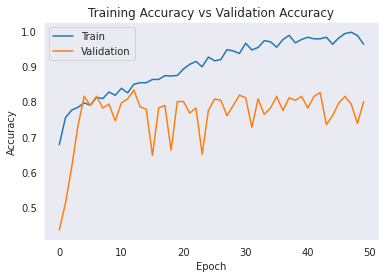

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

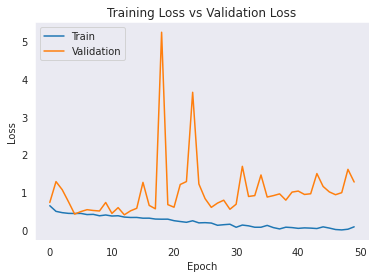

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]*100) + "%")

Loss: 1.889851450920105
Accuracy: 74.91525411605835%
